# Decision Tree Classifier

## Growing Decison Trees from scratch
Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. the Decision Tree is printed, and information gain based on entropy is used as the splitting measure.

In [ ]:
!pip install -U -q PyDrive
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
warnings.filterwarnings('ignore')

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1e7mP44DGtd-lnk1v7Rt9Cdkag6wh5s7r/view?usp=sharing'
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.csv')
data = pd.read_csv('data.csv')
print(data)

     feature1  feature2  feature3  feature4  class
0         5.0       3.5       1.3       0.3      0
1         6.9       3.1       4.9       1.5      1
2         5.8       2.6       4.0       1.2      1
3         6.7       3.0       5.2       2.3      2
4         5.1       3.3       1.7       0.5      0
..        ...       ...       ...       ...    ...
145       7.4       2.8       6.1       1.9      2
146       6.2       2.9       4.3       1.3      1
147       5.6       2.5       3.9       1.1      1
148       5.1       3.5       1.4       0.2      0
149       6.4       3.2       5.3       2.3      2

[150 rows x 5 columns]


In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=10)
data_train = train.reset_index(drop=True)
data_test = test.reset_index(drop=True)
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1, 1)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=10)

print("Train data length = ", len(data_train))
print("Train data shape = ", data_train.shape)
print("Test data length = ", len(data_test))
print("Test data shape = ", data_test.shape)

Train data length =  105
Train data shape =  (105, 5)
Test data length =  45
Test data shape =  (45, 5)


In [ ]:
def reduced_dframe(data, max_info_gain, value):
    idx = 0
    left = {}
    right = {}
    df_left = pd.DataFrame(left)
    df_right = pd.DataFrame(right)
    for i in data[max_info_gain]:
        if i >= value:
            df_right = df_right.append(data.loc[idx])
        else:
            df_left = df_left.append(data.loc[idx])
        idx = idx + 1
    df_left = df_left.drop(max_info_gain, 1)
    df_right = df_right.drop(max_info_gain, 1)

    return df_left.reset_index(drop=True), df_right.reset_index(drop=True)

In [ ]:
def calculate_entropy(col):
    entropy = 0
    counts = np.bincount(col)
    p = counts / len(col)
    for i in p:
        if i > 0:
            entropy = entropy + i * math.log(i, 2)

    return -entropy

In [ ]:
def information_gain(data, mask):
    i = sum(mask)
    j = len(mask) - i
    k = i + j
    if i == 0 or j == 0:
        info_gain = 0
    else:
        info_gain = calculate_entropy(data) - i / (k) * calculate_entropy(data[mask]) - j / (k) * calculate_entropy(
            data[-mask])

    return info_gain

In [ ]:
def max_info_gain_split(predictor, target):
    split_value = []
    info_gain = []
    options = predictor.sort_values().unique()[1:]
    for value in options:
        mask = predictor < value
        value_IG = information_gain(target, mask)
        info_gain.append(value_IG)
        split_value.append(value)
    if len(info_gain) == 0:
        return 0, 0
    else:
        best_info_gain = max(info_gain)
        best_info_gain_index = info_gain.index(best_info_gain)
        best_split = split_value[best_info_gain_index]
        return best_info_gain, best_split

In [ ]:
data.drop('class', axis=1).apply(max_info_gain_split, target=data['class'])

,feature1,feature2,feature3,feature4
0,0.557233,0.267911,0.918296,0.918296
1,5.600000,3.400000,3.000000,1.000000


In [ ]:
def get_best_split(y, data):
    masks = data.drop(y, axis=1).apply(max_info_gain_split, target=data[y])
    info_gain_val = 0
    for col in masks:
        if info_gain_val <= masks[col].loc[0]:
            info_gain_val = masks[col].loc[0]
            feature = col
            split_val = masks[col].loc[1]

    return feature, split_val, info_gain_val

In [ ]:
def print_decision_tree(data):
    left_branch = True
    right_branch = True

    print("***** 1st Level *****\n")

    print("\nROOT")
    root_10, root_20, root_30 = get_best_split('class', data)
    print("{}; split value = {}; information gain = {}".format(root_10, root_20, root_30))
    print("class, count")
    print(data['class'].value_counts())
    print("samples = {}".format(data.shape[0]))
    if root_30 == 0 or left_branch == False or right_branch == False:
        print("LEAF NODE")
        left_branch = False
        right_branch = False
    else:
        print("PARENT NODE")
        left_df_10, right_df_20 = reduced_dframe(data, root_10, root_20)

    print("\n\n***** 2nd Level *****\n")

    print("\nLEFT branch")
    left_11, left_21, left_31 = get_best_split('class', left_df_10)
    print("{}; split value = {}; information gain = {}".format(left_11, left_21, left_31))
    print("class, count")
    print(left_df_10['class'].value_counts())
    print("samples = {}".format(left_df_10.shape[0]))
    if left_31 == 0 or left_branch == False:
        print("LEAF NODE")
        left_branch = False
    else:
        print("PARENT NODE")
        left_df_11, left_df_21 = reduced_dframe(left_df_10, left_11, left_21)

    print("\nRIGHT branch")
    right_11, right_21, right_31 = get_best_split('class', right_df_20)
    right_df_12, right_df_22 = reduced_dframe(right_df_20, right_11, right_21)
    print("{}; split value = {}; information gain = {}".format(right_11, right_21, right_31))
    print("class, count")
    print(right_df_20['class'].value_counts())
    print("samples = {}".format(right_df_20.shape[0]))
    if right_31 == 0 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        right_df_12, right_df_22 = reduced_dframe(right_df_20, right_11, right_21)

    print("\n\n***** 3rd Level *****\n")

    print("\nLEFT-LEFT branch")
    print("LEAF NODE")

    print("\nRIGHT-LEFT branch")
    print("LEAF NODE")

    print("\nLEFT-RIGHT branch")
    right_12, right_22, right_32 = get_best_split('class', right_df_12)
    left_df_12, left_df_22 = reduced_dframe(right_df_12, right_12, right_22)
    print("{}; split value = {}; information gain = {}".format(right_12, right_22, right_32))
    print("class, count")
    print(right_df_12['class'].value_counts())
    print("samples = {}".format(right_df_12.shape[0]))
    if right_32 == 0 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        left_df_12, left_df_22 = reduced_dframe(right_df_12, right_12, right_22)

    print("\nRIGHT-RIGHT branch")
    right_12, right_22, right_32 = get_best_split('class', right_df_22)
    print("{}; split value = {}; information gain = {}".format(right_12, right_22, right_32))
    print("class, count")
    print(right_df_22['class'].value_counts())
    print("samples = {}".format(right_df_22.shape[0]))
    if right_32 == 0 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        right_df_12, right_df_22 = reduced_dframe(right_df_22, right_12, right_22)

    print("\n\n***** 4th Level *****\n")

    print("\nLEFT-LEFT-LEFT branch")
    print("LEAF NODE")

    print("\nRIGHT-LEFT-LEFT branch")
    print("LEAF NODE")

    print("\nLEFT-RIGHT-LEFT branch")
    print("LEAF NODE")

    print("\nRIGHT-RIGHT-LEFT branch")
    print("LEAF NODE")

    print("\nLEFT-LEFT-RIGHT branch")
    right_13, right_23, right_33 = get_best_split('class', left_df_12)
    print("{}; split value = {}; information gain = {}".format(right_13, right_23, right_33))
    print("class, count")
    print(left_df_12['class'].value_counts())
    print("samples = {}".format(left_df_12.shape[0]))
    if right_33 == 0 or right_33 == 1 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        left_df_12, left_df_22 = reduced_dframe(left_df_12, right_13, right_23)

    print("\nRIGHT-LEFT-RIGHT branch")
    right_13, right_23, right_33 = get_best_split('class', left_df_22)
    print("{}; split value = {}; information gain = {}".format(right_13, right_23, right_33))
    print("class, count")
    print(left_df_22['class'].value_counts())
    print("samples = {}".format(left_df_22.shape[0]))
    if right_33 == 0 or right_33 == 0 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        left_df_12, left_df_22 = reduced_dframe(left_df_22, right_13, right_23)

    print("\nLEFT-RIGHT-RIGHT branch")
    right_13, right_23, right_33 = get_best_split('class', right_df_12)
    print("{}; split value = {}; information gain = {}".format(right_13, right_23, right_33))
    print("class, count")
    print(right_df_12['class'].value_counts())
    print("samples = {}".format(right_df_12.shape[0]))
    if right_33 == 0 or right_33 == 1 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        right_df_12, right_df_22 = reduced_dframe(right_df_12, right_13, right_23)

    print("\nRIGHT-RIGHT-RIGHT branch")
    right_13, right_23, right_33 = get_best_split('class', right_df_22)
    print("{}; split value = {}; information gain = {}".format(right_12, right_23, right_33))
    print("class, count")
    print(right_df_22['class'].value_counts())
    print("samples = {}".format(right_df_22.shape[0]))
    if right_33 == 0 or right_33 == 1 or right_branch == False:
        print("LEAF NODE")
        right_branch = False
    else:
        print("PARENT NODE")
        right_df_12, right_df_22 = reduced_dframe(right_df_22, right_13, right_23)

In [ ]:
print(data_train.shape)

(105, 5)


In [ ]:
print_decision_tree(data_train)

***** 1st Level *****


ROOT
feature4; split value = 1.0; information gain = 0.9275265884316758
class, count
2    38
0    36
1    31
Name: class, dtype: int64
samples = 105
PARENT NODE


***** 2nd Level *****


LEFT branch
feature3; split value = 1.3; information gain = 0.0
class, count
0.0    36
Name: class, dtype: int64
samples = 36
LEAF NODE

RIGHT branch
feature3; split value = 4.8; information gain = 0.6788243996912714
class, count
2.0    38
1.0    31
Name: class, dtype: int64
samples = 69
PARENT NODE


***** 3rd Level *****


LEFT-LEFT branch
LEAF NODE

RIGHT-LEFT branch
LEAF NODE

LEFT-RIGHT branch
feature1; split value = 5.0; information gain = 0.14743141520988537
class, count
1.0    28
2.0     1
Name: class, dtype: int64
samples = 29
PARENT NODE

RIGHT-RIGHT branch
feature1; split value = 6.9; information gain = 0.036433327004803895
class, count
2.0    37
1.0     3
Name: class, dtype: int64
samples = 40
PARENT NODE


***** 4th Level *****


LEFT-LEFT-LEFT branch
LEAF NODE

RIG

In [ ]:
print(data_test.shape)

(45, 5)


In [ ]:
print_decision_tree(data_test)

***** 1st Level *****


ROOT
feature4; split value = 1.0; information gain = 0.8944518845341283
class, count
1    19
0    14
2    12
Name: class, dtype: int64
samples = 45
PARENT NODE


***** 2nd Level *****


LEFT branch
feature3; split value = 1.1; information gain = 0.0
class, count
0.0    14
Name: class, dtype: int64
samples = 14
LEAF NODE

RIGHT branch
feature3; split value = 5.0; information gain = 0.9629004147713269
class, count
1.0    19
2.0    12
Name: class, dtype: int64
samples = 31
PARENT NODE


***** 3rd Level *****


LEFT-LEFT branch
LEAF NODE

RIGHT-LEFT branch
LEAF NODE

LEFT-RIGHT branch
feature2; split value = 2.2; information gain = 0.0
class, count
1.0    19
Name: class, dtype: int64
samples = 19
LEAF NODE

RIGHT-RIGHT branch
feature2; split value = 2.7; information gain = 0.0
class, count
2.0    12
Name: class, dtype: int64
samples = 12
LEAF NODE


***** 4th Level *****


LEFT-LEFT-LEFT branch
LEAF NODE

RIGHT-LEFT-LEFT branch
LEAF NODE

LEFT-RIGHT-LEFT branch
LEAF

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=2, model='entropy'):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.model = model

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        samples, features = np.shape(X)
        if samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, samples, features)
            if best_split['info_gain'] > 0:
                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth + 1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth + 1)
                return Node(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree,
                            best_split['info_gain'])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        model = 'entropy'
        best_split = {}
        max_info_gain = float('-inf')
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, model)

                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['dataset_left'] = dataset_left
                        best_split['dataset_right'] = dataset_right
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def information_gain(self, parent, l_child, r_child, model="entropy"):
        wl = len(l_child) / len(parent)
        wr = len(r_child) / len(parent)
        gain = 0
        if model == 'entropy':
            gain = self.entropy(parent) - (wl * self.entropy(l_child)) - (wr * self.entropy(r_child))
        elif model == 'gini':
            gain = self.gini(parent) - (wl * self.gini(l_child)) - (wr * self.gini(r_child))
        return gain

    def entropy(self, y):
        entropy = 0
        classes = np.unique(y)
        for cls in classes:
            Pi = len(y[y == cls]) / len(y)
            entropy += -(Pi * np.log2(Pi))
        return entropy

    def gini_index(self, y):
        gini = 0
        classes = np.unique(y)
        for cls in classes:
            Pi = len(y[y == cls]) / len(y)
            gini += Pi ** 2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):
        if not tree:
            tree = self.root
        if tree.value is not None:
            print(tree.value)
        else:
            print("X " + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % indent, end=" ")
            self.print_tree(tree.left, indent + indent)
            print("%sright" % indent, end=" ")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions

    def make_predictions(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)

In [ ]:
clf = DecisionTreeClassifier(min_samples_split=9, max_depth=10, model='gini')
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtest)
accuracy = accuracy_score(ytest, ypred)
print(accuracy)

0.9333333333333333


## Decision Tree using Sklearn Library

Here, the Decision Tree Classifier from the Sklearn Library is used and the gini index is used as a splitting measure. Finally, print the Decision Tree and comparison made between this tree and the tree built manually.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

link = 'https://drive.google.com/file/d/1e7mP44DGtd-lnk1v7Rt9Cdkag6wh5s7r/view?usp=sharing'
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('data.csv')
data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  150 non-null    float64
 1   feature2  150 non-null    float64
 2   feature3  150 non-null    float64
 3   feature4  150 non-null    float64
 4   class     150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [ ]:
print(data)

     feature1  feature2  feature3  feature4  class
0         5.0       3.5       1.3       0.3      0
1         6.9       3.1       4.9       1.5      1
2         5.8       2.6       4.0       1.2      1
3         6.7       3.0       5.2       2.3      2
4         5.1       3.3       1.7       0.5      0
..        ...       ...       ...       ...    ...
145       7.4       2.8       6.1       1.9      2
146       6.2       2.9       4.3       1.3      1
147       5.6       2.5       3.9       1.1      1
148       5.1       3.5       1.4       0.2      0
149       6.4       3.2       5.3       2.3      2

[150 rows x 5 columns]


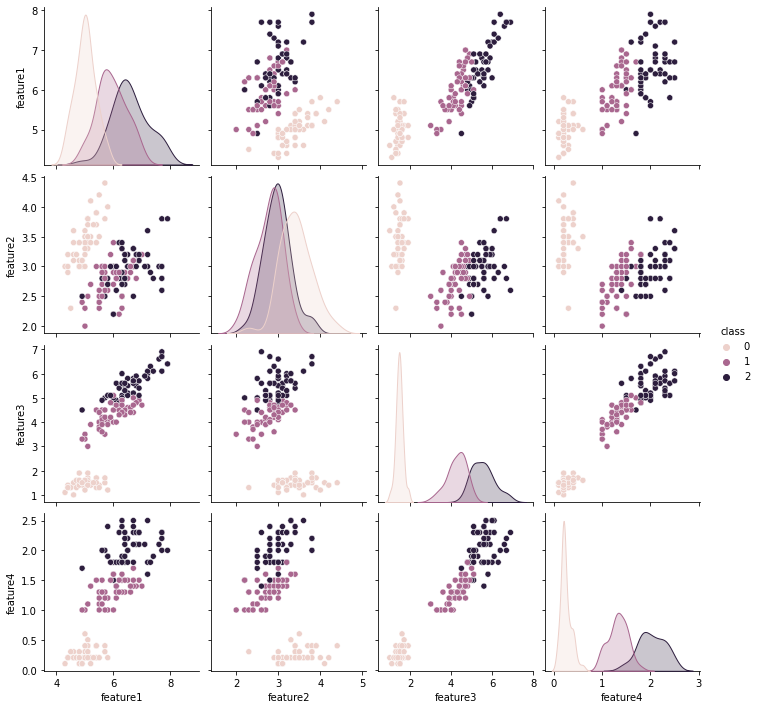

In [ ]:
sns.pairplot(data=data, hue="class")

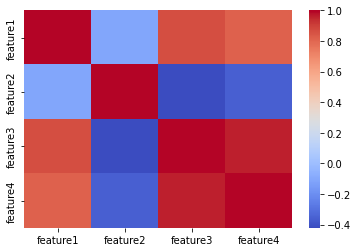

In [ ]:
newdata = data.drop(['class'], axis=1)
corr = newdata.corr()
sns.heatmap(corr, cmap='coolwarm')
independent = data.copy()
independent = independent.drop(['feature1', 'feature2', 'feature3', 'feature4'], axis=1)
dependent = data.copy()
dependent = dependent.drop(['class'], axis=1)
actual_data = data.copy()
x_data = actual_data.drop(['class'], axis=1)
y_data = actual_data.drop(['feature1', 'feature2', 'feature3', 'feature4'], axis=1)

In [ ]:
dependent_train, dependent_test, independent_train, independent_test = train_test_split(dependent, independent, test_size=0.30, random_state=10)
print('Train Data: ', independent_train.shape)
print("Test Data: ", dependent_test.shape)

Train Data:  (105, 1)
Test Data:  (45, 4)


In [ ]:
print("Train Set: \n", independent_train.value_counts(normalize=True))
print("\nTest Set: \n",independent_test.value_counts(normalize=True))

Train Set: 
 class
2        0.361905
0        0.342857
1        0.295238
dtype: float64

Test Set: 
 class
1        0.422222
0        0.311111
2        0.266667
dtype: float64


In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=10, criterion='gini')
decision_tree_model.fit(dependent_train, independent_train)
decision_tree_model.score(x_data, y_data)

0.9866666666666667

In [ ]:
decision_tree_model.score(dependent_train, independent_train)

1.0

In [ ]:
decision_tree_model.score(dependent_test, independent_test)

0.9555555555555556

In [ ]:
independent_predict = decision_tree_model.predict(dependent_test)
print(classification_report(independent_test, independent_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.89      0.94        19
           2       0.86      1.00      0.92        12

    accuracy                           0.96        45
   macro avg       0.95      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [ ]:
training_accuracy = []
test_accuracy = []
for i in range(1, 10):
    tree_model = DecisionTreeClassifier(random_state=20, criterion='gini', max_depth=i)
    tree_model.fit(dependent_train, independent_train)
    training_accuracy.append(tree_model.score(dependent_train, independent_train))
    test_accuracy.append(tree_model.score(dependent_test, independent_test))
df = pd.DataFrame({'Max Depth': range(1, 10), 'Train Accuracy': training_accuracy, 'Test Accuracy': test_accuracy})
df.head()

,Max Depth,Train Accuracy,Test Accuracy
0,1,0.704762,0.577778
1,2,0.961905,0.933333
2,3,0.971429,0.933333
3,4,0.980952,0.977778
4,5,0.990476,0.933333


Text(0.5, 1.0, 'Depth of Tree vs Accuracy')

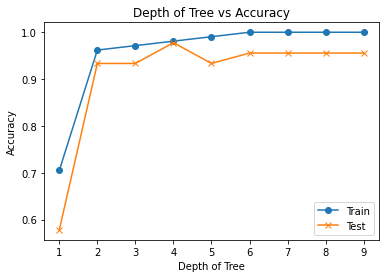

In [ ]:
plt.plot(df['Max Depth'], df['Train Accuracy'], marker='o')
plt.plot(df['Max Depth'], df['Test Accuracy'], marker='x')
plt.xlabel('Depth of Tree')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.title("Depth of Tree vs Accuracy")

In [ ]:
decision_tree_model = DecisionTreeClassifier(random_state=20, criterion='gini', max_depth=4, min_samples_split=6, min_samples_leaf=3, max_leaf_nodes=6)
decision_tree_model.fit(dependent_train, independent_train)
decision_tree_model.score(dependent_test, independent_test)

0.9777777777777777

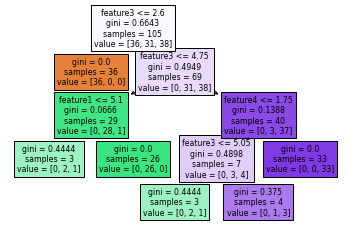

In [ ]:
decision_tree = plot_tree(decision_tree=decision_tree_model, feature_names=dependent_train.columns, filled=True, precision=4)

The accuracy for the manually build Decision Tree Function is 93% and that for the sklearn function is 97%. They are both almost similar, but the sklearn function naturally is optimized and faster with better accuracy as well. Both the functions also produce a Decision Tree, where the sklearn function produces a very descriptive and visually interesting decision tree as compared to the manual Decision Tree.

# Linear Regression

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable.

## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [ ]:
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

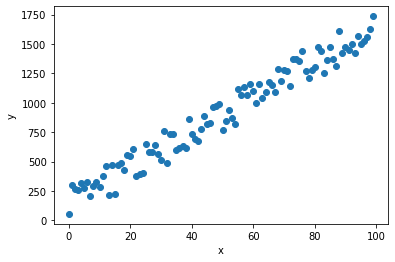

In [ ]:
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
def compute_cost(ip, op, params):
    num_samples = len(ip)
    cost_sum = 0.0
    for x, y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    cost = cost_sum / num_samples

    return cost

## Implemented Linear Regression using Batch Gradient Descent from scratch


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [ ]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])
    s = ip.shape[0]
    initial_cost = compute_cost(ip, op, params)
    theta0 = ip[40]
    theta1 = ip[40]
    params = np.array([theta0, theta1])
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params

        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')

        grad1 = (alpha / s) * sum([(theta0 + theta1 * ip[i] - op[i]) for i in range(s)])
        grad0 = (alpha / s) * sum([(theta0 + theta1 * ip[i] - op[i]) * ip[i] for i in range(s)])
        theta0 = theta0 - grad0
        theta1 = theta1 - grad1
        params = np.array([theta0, theta1])
        iteration = iteration + 1

    return params, cost, params_store

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)

--------------------------
iteration: 0
cost: 1990871.8640726209
--------------------------
iteration: 1
cost: 1639562.1270511555
--------------------------
iteration: 2
cost: 1358265.8799367903
--------------------------
iteration: 3
cost: 1133160.9106267034
--------------------------
iteration: 4
cost: 953155.7738881853
--------------------------
iteration: 5
cost: 809350.3205495616
--------------------------
iteration: 6
cost: 694602.8011376141
--------------------------
iteration: 7
cost: 603182.4897935209
--------------------------
iteration: 8
cost: 530490.9336265959
--------------------------
iteration: 9
cost: 472838.2703021751
--------------------------
iteration: 10
cost: 427263.73493475374
--------------------------
iteration: 11
cost: 391391.626529357
--------------------------
iteration: 12
cost: 363315.7288092884
--------------------------
iteration: 13
cost: 341506.56416354247
--------------------------
iteration: 14
cost: 324736.96994880086
--------------------------
it

## Implemented Stochastic Gradient Descent from scratch

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [ ]:
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    num_samples = len(input_var)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])
    s = ip.shape[0]
    initial_cost = compute_cost(ip, op, params)
    theta0 = ip[40]
    theta1 = ip[40]
    params = np.array([theta0, theta1])
    i = 0
    for x, y in zip(input_var, output_var):
        cost[i] = compute_cost(input_var, output_var, params)
        params_store[:, i] = params

        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')

        random_index = np.random.randint(s)
        rand_x = ip[random_index:random_index + 1]
        rand_y = op[random_index:random_index + 1]
        print("random number = {}".format(random_index))
        grad1 = (alpha / s) * sum([(theta0 + theta1 * rand_x[i] - rand_y[i]) for i in range(len(rand_y))])
        grad0 = (alpha / s) * sum([(theta0 + theta1 * rand_x[i] - rand_y[i]) * rand_y[i] for i in range(len(rand_y))])
        theta0 = theta0 - grad0
        theta1 = theta1 - grad1
        params = np.array([theta0, theta1])
        i = i + 1

    return params, cost, params_store

In [ ]:
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)

--------------------------
iteration: 0
cost: 2120520.920115481
random number = 78
--------------------------
iteration: 1
cost: 2074978.8154432806
random number = 35
--------------------------
iteration: 2
cost: 1959200.3523397066
random number = 5
--------------------------
iteration: 3
cost: 1958964.958411901
random number = 52
--------------------------
iteration: 4
cost: 1885347.4932839763
random number = 77
--------------------------
iteration: 5
cost: 1832517.5616867668
random number = 47
--------------------------
iteration: 6
cost: 1809534.725977861
random number = 72
--------------------------
iteration: 7
cost: 1799389.993403954
random number = 62
--------------------------
iteration: 8
cost: 1764452.3607950038
random number = 2
--------------------------
iteration: 9
cost: 1750925.6044078204
random number = 4
--------------------------
iteration: 10
cost: 1710948.0917868298
random number = 12
--------------------------
iteration: 11
cost: 1653389.8236091423
random number = 

## Calculated Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm

In [ ]:
def calculate_yHat(x, params):
    yHat = []
    for i in range(len(params[0])):
        yHat.append(params[0][i] * input_var[i] + params[1][i])
    return yHat


def MSE(true_Y, predicted_Y):
    n = len(true_Y)
    summ_value = 0
    for i in range(0, n):
        diff_value = true_Y[i] - predicted_Y[i]
        squared_diff = diff_value ** 2
        summ_value = summ_value + squared_diff
    return math.sqrt(summ_value / n)

In [ ]:
yHat_BGD = calculate_yHat(input_var, params_store_batch)
yHat_SGD = calculate_yHat(x_train, params_store[:80])
print("Calculated RMS in batch gradient descent(manual compute) = {}".format(MSE(output_var, yHat_BGD)))
print("Calculated RMS in batch gradient descent(sklearn.metric) = {}".format(mean_squared_error(output_var, yHat_BGD, squared=False)))
print("Calculated RMS in stochastic gradient descent(manual compute) = {}".format(MSE(x_train, yHat_SGD)))
print("Calculated RMS in stochastic gradient descent(sklearn.metric) = {}".format(mean_squared_error(x_train, yHat_SGD[:80], squared=False)))

Calculated RMS in batch gradient descent(manual compute) = 75943.0476880426
Calculated RMS in batch gradient descent(sklearn.metric) = 75943.0476880426
Calculated RMS in stochastic gradient descent(manual compute) = 29717.271277779528
Calculated RMS in stochastic gradient descent(sklearn.metric) = 29717.27127777952


In [ ]:
print(f'Batch RMS:      {np.sqrt(np.mean(np.square(params_hat_batch[0] + params_hat_batch[1]*x_test - y_test)))}')
print(f'Stochastic RMS: {np.sqrt(np.mean(np.square(params_hat[0] + params_hat[1]*x_test - y_test)))}')

Batch RMS:      1010.1842190104973
Stochastic RMS: 918.8381545271391


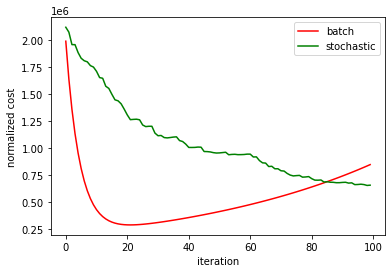

min cost with BGD: 286023.91785089934
min cost with SGD: 652408.5621469002


In [ ]:
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

The batch gradient descent method works best with the given data. This is due to the small size of the data set. However, if the data sample is large, the story will be different. The batch gradient descent will take much longer to process for every data set. In this case, it is sufficient to sample enough data from specific parts of the entire data set to predict the model. A good decision is to use specific parts or locations of the population that should be suitable for predicting the model. Following the generation of the model, some training data can be used to further validate the model.

# Linear Regression Analytical Problem
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

### ***Manually: Using mathematical/analytical approach***

Let $θ$ = $(θ_0, θ_1, θ_2)$

In [ ]:
X = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
print("X =\n", X)

X =
 [[1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]


In [ ]:
y = np.array([[0], [1.5], [2], [2.5]])
print("y =\n", y)

y =
 [[0. ]
 [1.5]
 [2. ]
 [2.5]]


Using Least Squares Linear Regression, the solution for $θ$ is given by:
$θ$ = $(X^TX)^{-1}X^Ty$



$X^TX$ = 

In [ ]:
print(np.dot(X.transpose(), X))

[[4 2 2]
 [2 2 1]
 [2 1 2]]


$X^TX^{-1}$ = 

In [ ]:
print(np.linalg.inv(np.dot(X.transpose(), X)))

[[ 0.75 -0.5  -0.5 ]
 [-0.5   1.    0.  ]
 [-0.5   0.    1.  ]]


$(X^TX)^{-1}X^T$ = 

In [ ]:
print(np.dot((np.linalg.inv(np.dot(X.transpose(), X))), X.transpose()))

[[ 0.75  0.25  0.25 -0.25]
 [-0.5  -0.5   0.5   0.5 ]
 [-0.5   0.5  -0.5   0.5 ]]


$θ$ = $(X^TX)^{-1}X^Ty$ = 

In [ ]:
print(np.dot((np.dot((np.linalg.inv(np.dot(X.transpose(), X))), X.transpose())), y))

[[0.25]
 [1.5 ]
 [1.  ]]


$(θ_0, θ_1, θ_2)$ = (0.25, 1.5, 1)

**Model: y = 0.25 + 1.5$x_1$ + $x_2$**

### ***Code: Using Python libraries***

In [ ]:
data = {'X1': [0, 0, 1, 1], 'X2': [0, 1, 0, 1], 'Y': [0, 1.5, 2, 2.5]}
df = pd.DataFrame(data)
print(df)

   X1  X2    Y
0   0   0  0.0
1   0   1  1.5
2   1   0  2.0
3   1   1  2.5


In [ ]:
x = df.drop('Y', axis=1)
print("x =\n", x)
y = data['Y']
print("\ny =\n", y)

x =
    X1  X2
0   0   0
1   0   1
2   1   0
3   1   1

y =
 [0, 1.5, 2, 2.5]


In [ ]:
multiple_LR = LinearRegression()
multiple_LR.fit(x, y)
y_predict = multiple_LR.predict(x)
print(y_predict)

[0.25 1.25 1.75 2.75]


Therefore the values for $θ_1$ and $θ_2$ respectively, will be:

In [ ]:
coef = multiple_LR.coef_
print(coef)

[1.5 1. ]


$(θ_1, θ_2)$ = (1.5, 1)

In [ ]:
b01 = y_predict[0] - coef[0] * data['X1'][0] - coef[1] * data['X2'][0]
b02 = y_predict[1] - coef[1] * data['X1'][1] - coef[1] * data['X2'][1]
if b01 == b02:
    b0 = b01
    print(b0)

0.25


$θ_0$ = 0.25

**Model: y = 0.25 + 1.5$x_1$ + $x_2$**